In [144]:
%tensorflow_version 1.x

!pip install mne

import os
import numpy as np
import pandas as pd
import mne
import csv, json
import datetime
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split

In [0]:
def undersample(X, new_freq = 50, current_freq = 500, verbose = False):
    if current_freq % new_freq > 0: 
        print('(current_freq / new_frequency) should be an integer')
        return 0
    ratio = new_freq / current_freq
    num_points = int(X.shape[1] * ratio)
    indices = np.arange(start = 0, stop = X.shape[1], step = int(ratio**-1))
    X_new = X[:,indices,:]
    if verbose: 
        print('Old dimensions:',X.shape)
        print('New dimensions:',X_new.shape)
    return X_new

def edf_to_dataset(edf_path, scores_path):
    edf = mne.io.read_raw_edf(edf_path)
    sampling_rate = int(edf.info['sfreq'])
    name = datetime.datetime.utcfromtimestamp(edf.info['meas_date'][0]).strftime('%Y-%m-%d %H:%M:%S')
    
    header = (','.join(edf.ch_names)).split(',')
    df = edf.get_data().T
    
    scores = np.squeeze( pd.read_excel(scores_path, keep_default_na=False).values )
    values_per_window = int(df.shape[0]/scores.shape[0])
    num_windows = scores.shape[0]
    
    df = df[:num_windows*values_per_window]
    df = np.reshape(df, newshape=(num_windows, values_per_window, 2))

    scores[scores=='D'] = 'WA'
    scores[scores=='SS'] = 'WA'
    
    # scores[scores=='NA'] = 'NR'
    # scores[scores=='WA'] = 'W'
    # scores[scores=='RA'] = 'R'

    to_drop = (scores=='NA') | (scores=='WA') | (scores=='RA')
    # print(df.shape, scores.shape)
    df = df[~to_drop]
    scores = scores[~to_drop]
    # print(df.shape, scores.shape)

    
    return df, scores

def edfs_to_dataset(folder, undersample_freq = 500):
    dataset_names = []
    for filename in sorted(os.listdir(folder), key=lambda x: int(x.split('_')[0][3:]) ):
        name = filename.split('.')[0].replace('-', '_')
        if name not in dataset_names: dataset_names.append(name)
    print(dataset_names)

    for dataset in dataset_names:
        edf_path = folder + '/' + dataset + '.edf'
        excel_path = folder + '/' + dataset + '.xls'
        X, Y = edf_to_dataset(edf_path, excel_path)
        if undersample_freq < 500:
            X = undersample(X, new_freq=undersample_freq)
        yield X, Y

def merge_datasets(list_X, list_Y):
    X_merged, Y_merged = None, None
    for i in range(len(list_X)):
        X = list_X[i]
        Y = list_Y[i]
        # print(X.shape)
        # print(Y.shape)
        X_merged = X if X_merged is None else np.vstack([X_merged, X])
        Y_merged = Y if Y_merged is None else np.hstack([Y_merged, Y])
        
    # print(X_merged.shape)
    # print(Y_merged.shape)
    return X_merged, Y_merged

def labels_to_onehot(Y, categories = {}):
    Y = Y.copy()
    count = 0
    for i in range(len(Y)):
        value = Y[i]
        if not value in categories:
            categories[value] = count
            count += 1
        Y[i] = categories[value]

    Y = Y.astype(int)
    Y_onehot = np.zeros((Y.shape[0], len(categories)))
    Y_onehot[np.arange(Y.shape[0]), Y] = 1

    return Y_onehot, categories


In [146]:
from google.colab import drive
drive.mount('/content/drive')
!rm -r /content/VEH\ Tx\ \(N=10\)
!cp /content/drive/My\ Drive/VEH-Tx.zip ./
!unzip ./VEH-Tx.zip -d ./
os.rename('./VEH Tx (N=10)/Veh72-02142015.xls', './VEH Tx (N=10)/Veh72_02142015.xls')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  ./VEH-Tx.zip
   creating: ./VEH Tx (N=10)/
 extracting: ./VEH Tx (N=10)/Veh72-02142015.xls  
 extracting: ./VEH Tx (N=10)/Veh93_02272015.xls  
 extracting: ./VEH Tx (N=10)/Veh70_02202015.edf  
 extracting: ./VEH Tx (N=10)/Veh74_02032015.xls  
 extracting: ./VEH Tx (N=10)/Veh70_02202015.xls  
 extracting: ./VEH Tx (N=10)/Veh72_02142015.edf  
 extracting: ./VEH Tx (N=10)/Veh74_02032015.edf  
 extracting: ./VEH Tx (N=10)/Veh93_02272015.edf  
 extracting: ./VEH Tx (N=10)/Veh128_01182016.xls  
 extracting: ./VEH Tx (N=10)/Veh122_01072016.edf  
 extracting: ./VEH Tx (N=10)/Veh116_01292016.edf  
 extracting: ./VEH Tx (N=10)/Veh124_01052016.edf  
 extracting: ./VEH Tx (N=10)/Veh116_01292016.xls  
 extracting: ./VEH Tx (N=10)/Veh122_01072016.xls  
 extracting: ./VEH Tx (N=10)/Veh120_01112016.edf  
 extracting: ./VEH Tx (N=10)/Veh128_01182016.edf  
 extractin

In [202]:
datasets_folder = './VEH Tx (N=10)'
categories = {}
datasets_X, datasets_Y = [], []
for X,Y in edfs_to_dataset(datasets_folder):
    datasets_X.append(X)
    datasets_Y.append(Y)

['Veh70_02202015', 'Veh72_02142015', 'Veh74_02032015', 'Veh93_02272015', 'Veh116_01292016', 'Veh118_01182016', 'Veh120_01112016', 'Veh122_01072016', 'Veh124_01052016', 'Veh128_01182016']
Extracting EDF parameters from /content/VEH Tx (N=10)/Veh70_02202015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/VEH Tx (N=10)/Veh72_02142015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/VEH Tx (N=10)/Veh74_02032015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/VEH Tx (N=10)/Veh93_02272015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/VEH Tx (N=10)/Veh116_01292016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF pa

In [203]:
X_train, Y_train = merge_datasets(datasets_X[5:], datasets_Y[5:])
X_val, Y_val = merge_datasets(datasets_X[0:5], datasets_Y[0:5])

Y_train, categories = labels_to_onehot(Y_train, {})
Y_val, categories = labels_to_onehot(Y_val, {})

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(categories)

(7534, 500, 2) (7534, 3)
(6997, 500, 2) (6997, 3)
{'W': 0, 'NR': 1, 'R': 2}


In [0]:
# sample_folder = './'
# file_name = 'Veh70_02202015'

# categories = {}
# X, Y = edf_to_dataset(sample_folder+file_name+'.edf', sample_folder+file_name+'.xls')

# count = 0
# for i in range(len(Y)):
#     value = Y[i]
#     if not value in categories:
#         categories[value] = count
#         count += 1
#     Y[i] = categories[value]

# Y = Y.astype(int)
# Y_onehot = np.zeros((Y.shape[0], len(categories)))
# print(Y_onehot.shape)
# print(categories)
# Y_onehot[np.arange(Y.shape[0]), Y] = 1

# print(X.shape, Y_onehot.shape)

In [0]:
import tensorflow.keras as keras

class CNN_Scorer(keras.Model):

    def __init__(self, num_classes=6, filters=[10, 10], kernel_size=4, max_pool_size=2, use_batch_normalization=False, embedding_dimension=1000, dropout=0.4):
        super(CNN_Scorer, self).__init__(name='CNN')
        self.pipeline = []
        
        for num_filters in filters:
            self.pipeline.append( keras.layers.Conv1D(num_filters, kernel_size, activation='relu') )
            if use_batch_normalization: self.pipeline.append( keras.layers.BatchNormalization() )
            self.pipeline.append( keras.layers.MaxPool1D(max_pool_size) )
            
        self.pipeline.append( keras.layers.Flatten() )

        if embedding_dimension > 0:
            self.pipeline.append( keras.layers.Dense(embedding_dimension, activation='relu') )
            if dropout > 0: self.pipeline.append( keras.layers.Dropout(dropout) )

        self.pipeline.append( keras.layers.Dense(num_classes, activation='softmax') )

    def call(self, x):
        for layer in self.pipeline:
            # print(x.shape)
            x = layer(x)
        return x
    

In [206]:
model = CNN_Scorer(num_classes=len(categories), filters=[5, 5, 5, 5, 5, 5], use_batch_normalization=True, embedding_dimension=0, dropout=0.4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=X_train.shape)
model.summary()
# Y_hat = model.predict(X)
# model.evaluate(X, Y_onehot)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_290 (Conv1D)          multiple                  45        
_________________________________________________________________
batch_normalization_183 (Bat multiple                  20        
_________________________________________________________________
max_pooling1d_290 (MaxPoolin multiple                  0         
_________________________________________________________________
conv1d_291 (Conv1D)          multiple                  105       
_________________________________________________________________
batch_normalization_184 (Bat multiple                  20        
_________________________________________________________________
max_pooling1d_291 (MaxPoolin multiple                  0         
_________________________________________________________________
conv1d_292 (Conv1D)          multiple                  105     

In [217]:
print(model.evaluate(X_val, Y_val))
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20)

6997/6997 [==============================] - 1s 195us/sample - loss: 0.4724 - acc: 0.8872
[0.47240602481397725, 0.88723737]
Train on 7534 samples, validate on 6997 samples
Epoch 1/20
7534/7534 [==============================] - 5s 615us/sample - loss: 0.0605 - acc: 0.9772 - val_loss: 0.3929 - val_acc: 0.9055
Epoch 2/20
7534/7534 [==============================] - 5s 623us/sample - loss: 0.0577 - acc: 0.9785 - val_loss: 0.3693 - val_acc: 0.9125
Epoch 3/20
7534/7534 [==============================] - 5s 615us/sample - loss: 0.0559 - acc: 0.9818 - val_loss: 0.3912 - val_acc: 0.9061
Epoch 4/20
7534/7534 [==============================] - 5s 617us/sample - loss: 0.0692 - acc: 0.9760 - val_loss: 0.3224 - val_acc: 0.9190
Epoch 5/20
7534/7534 [==============================] - 5s 635us/sample - loss: 0.0558 - acc: 0.9809 - val_loss: 0.4109 - val_acc: 0.9048
Epoch 6/20
7534/7534 [==============================] - 5s 621us/sample - loss: 0.0664 - acc: 0.9758 - val_loss: 0.4443 - val_acc: 0.8982


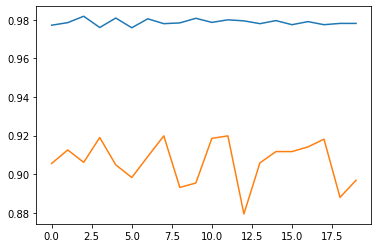

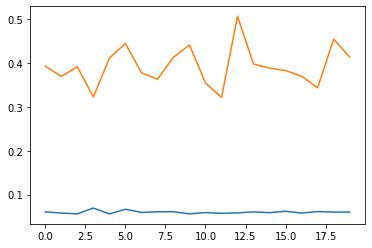

Maximum acc on training: 0.98181576 at epoch: 2
Maximum acc on validation: 0.91982275 at epoch: 7


In [218]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

print('Maximum acc on training:', np.max(history.history['acc']),'at epoch:', np.argmax(history.history['acc']))
print('Maximum acc on validation:', np.max(history.history['val_acc']),'at epoch:', np.argmax(history.history['val_acc']))